In [34]:
from collections import defaultdict
import math
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pysam
from scipy import stats

In [3]:
SAMPLES = os.listdir('../raw/')
SAMPLES

['polya-untreated',
 'polya-siLuc',
 'polya-siLin28a',
 'clip-35L33G',
 'rpf-siLuc',
 'rpf-siLin28a']

# 1. Bam --> {sample : {gene ID : read count}}

In [4]:
def read_count_per_gene(fileIn):
    iterBam       = pysam.AlignmentFile(fileIn, 'rb')
    dctReads      = remove_multimapped_reads(iterBam)
    dctGenes      = ignore_redundant_isoforms(dctReads)
    dctReadCounts = count_reads(dctGenes)
    return dctReadCounts

In [5]:
def remove_multimapped_reads(iterBam):
    dctReads = defaultdict(set)
    for read in iterBam:
        if read.flag & 4 == 4: # FLAG 4 == unmapped
            continue # Ignore unmapped
        geneId   = read.reference_name.split('|')[1]
        geneName = read.reference_name.split('|')[5]
        dctReads[read.query_name].add(f'{geneName}|{geneId}')
    dctReadsFiltered = {}
    for read, genes in dctReads.items():
        if len(genes) == 1:
            for gene in genes:
                dctReadsFiltered[read] = gene
    return dctReadsFiltered

In [6]:
def ignore_redundant_isoforms(dctReads):
    dctGenes = defaultdict(set)
    for read, gene in dctReads.items():
        dctGenes[gene].add(read)
    return dctGenes

In [7]:
def count_reads(dctGenes):
    dctReadCounts = {}
    for gene, reads in dctGenes.items():
        dctReadCounts[gene] = len(reads)
    return dctReadCounts

In [8]:
dctSamples = {}
for sample in SAMPLES:
    dctSamples[sample] = read_count_per_gene(f'../alignments/{sample}.bam')
    print(f'count {sample}: complete!')

count polya-untreated: complete!
count polya-siLuc: complete!
count polya-siLin28a: complete!
count clip-35L33G: complete!
count rpf-siLuc: complete!
count rpf-siLin28a: complete!


# 2. Make dataframe

## 2.1. Make and save dataframe

In [9]:
dfCounts = pd.DataFrame(dctSamples)
dfCounts.to_csv('read-count.txt', sep='\t')
dfCounts

,polya-untreated,polya-siLuc,polya-siLin28a,clip-35L33G,rpf-siLuc,rpf-siLin28a
Taf5l|ENSMUSG00000038697.16,1618.0,1240.0,1851.0,1846.0,554.0,584.0
Zdhhc15|ENSMUSG00000033906.6,217.0,157.0,187.0,564.0,132.0,138.0
Hebp1|ENSMUSG00000042770.9,323.0,283.0,445.0,152.0,423.0,332.0
Rpl7|ENSMUSG00000043716.14,7886.0,3941.0,5051.0,4613.0,3266.0,1892.0
Bptf|ENSMUSG00000040481.18,5675.0,4798.0,6381.0,6219.0,980.0,583.0
...,...,...,...,...,...,...
Trav6-7-dv9|ENSMUSG00000095126.4,NaN,NaN,NaN,NaN,NaN,1.0
Gm5942|ENSMUSG00000083561.4,NaN,NaN,NaN,NaN,NaN,1.0
Gm7423|ENSMUSG00000116647.2,NaN,NaN,NaN,NaN,NaN,1.0
Gm26038|ENSMUSG00000088776.3,NaN,NaN,NaN,NaN,NaN,1.0


## 2.2. Discard genes with NaN

In [21]:
dfFiltered = dfCounts.dropna(axis=0)
dfFiltered

,polya-untreated,polya-siLuc,polya-siLin28a,clip-35L33G,rpf-siLuc,rpf-siLin28a
Taf5l|ENSMUSG00000038697.16,1618.0,1240.0,1851.0,1846.0,554.0,584.0
Zdhhc15|ENSMUSG00000033906.6,217.0,157.0,187.0,564.0,132.0,138.0
Hebp1|ENSMUSG00000042770.9,323.0,283.0,445.0,152.0,423.0,332.0
Rpl7|ENSMUSG00000043716.14,7886.0,3941.0,5051.0,4613.0,3266.0,1892.0
Bptf|ENSMUSG00000040481.18,5675.0,4798.0,6381.0,6219.0,980.0,583.0
...,...,...,...,...,...,...
Slc6a14|ENSMUSG00000031089.8,1.0,3.0,4.0,15.0,5.0,15.0
Folh1|ENSMUSG00000001773.15,1.0,1.0,9.0,20.0,9.0,16.0
Gm14024|ENSMUSG00000085485.2,1.0,3.0,1.0,4.0,2.0,4.0
Gm30091|ENSMUSG00000117637.2,1.0,1.0,2.0,9.0,1.0,1.0


## 2.3. Discard genes with low read counts

In [22]:
RPF_CUTOFF  = 80
CLIP_CUTOFF = 30

In [23]:
dfFiltered = dfFiltered[dfFiltered['rpf-siLuc'] >= RPF_CUTOFF]\
                       [dfFiltered['clip-35L33G'] >= CLIP_CUTOFF]
dfFiltered

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,polya-untreated,polya-siLuc,polya-siLin28a,clip-35L33G,rpf-siLuc,rpf-siLin28a
Taf5l|ENSMUSG00000038697.16,1618.0,1240.0,1851.0,1846.0,554.0,584.0
Zdhhc15|ENSMUSG00000033906.6,217.0,157.0,187.0,564.0,132.0,138.0
Hebp1|ENSMUSG00000042770.9,323.0,283.0,445.0,152.0,423.0,332.0
Rpl7|ENSMUSG00000043716.14,7886.0,3941.0,5051.0,4613.0,3266.0,1892.0
Bptf|ENSMUSG00000040481.18,5675.0,4798.0,6381.0,6219.0,980.0,583.0
...,...,...,...,...,...,...
H4c8|ENSMUSG00000060981.8,5.0,7.0,5.0,462.0,6718.0,4907.0
Gm10616|ENSMUSG00000108599.2,6.0,19.0,17.0,110.0,1706.0,1391.0
Myh8|ENSMUSG00000055775.17,2.0,43.0,13.0,55.0,1287.0,669.0
H2bc14|ENSMUSG00000114279.2,2.0,3.0,3.0,722.0,3482.0,2083.0


## 2.4. Discard Hist

In [24]:
dfFiltered.reset_index(inplace=True)
dfFiltered = dfFiltered[dfFiltered['index'].apply(lambda x: not x.startswith('Hist'))]
dfFiltered

,index,polya-untreated,polya-siLuc,polya-siLin28a,clip-35L33G,rpf-siLuc,rpf-siLin28a
0,Taf5l|ENSMUSG00000038697.16,1618.0,1240.0,1851.0,1846.0,554.0,584.0
1,Zdhhc15|ENSMUSG00000033906.6,217.0,157.0,187.0,564.0,132.0,138.0
2,Hebp1|ENSMUSG00000042770.9,323.0,283.0,445.0,152.0,423.0,332.0
3,Rpl7|ENSMUSG00000043716.14,7886.0,3941.0,5051.0,4613.0,3266.0,1892.0
4,Bptf|ENSMUSG00000040481.18,5675.0,4798.0,6381.0,6219.0,980.0,583.0
...,...,...,...,...,...,...,...
8011,H4c8|ENSMUSG00000060981.8,5.0,7.0,5.0,462.0,6718.0,4907.0
8012,Gm10616|ENSMUSG00000108599.2,6.0,19.0,17.0,110.0,1706.0,1391.0
8013,Myh8|ENSMUSG00000055775.17,2.0,43.0,13.0,55.0,1287.0,669.0
8014,H2bc14|ENSMUSG00000114279.2,2.0,3.0,3.0,722.0,3482.0,2083.0


# 3. Calculate CLIP enrichment and ribosomal density change

In [27]:
PSEUDO = 0.01
pseudoLog2 = lambda x: math.log2(x + PSEUDO)

In [28]:
dfLfc = dfFiltered[:]

In [29]:
dfLfc['clip-enrich'] = dfFiltered['clip-35L33G'].apply(pseudoLog2).sub(dfFiltered['polya-untreated'].apply(pseudoLog2))
dfLfc['rib-density-siLin28a'] = dfFiltered['rpf-siLin28a'].apply(pseudoLog2).sub(dfFiltered['polya-siLin28a'].apply(pseudoLog2))
dfLfc['rib-density-siLuc'] = dfFiltered['rpf-siLuc'].apply(pseudoLog2).sub(dfFiltered['polya-siLuc'].apply(pseudoLog2))
dfLfc['rib-density-change'] = dfLfc['rib-density-siLin28a'].sub(dfLfc['rib-density-siLuc'])
dfLfc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,index,polya-untreated,polya-siLuc,polya-siLin28a,clip-35L33G,rpf-siLuc,rpf-siLin28a,clip-enrich,rib-density-siLin28a,rib-density-siLuc,rib-density-change
0,Taf5l|ENSMUSG00000038697.16,1618.0,1240.0,1851.0,1846.0,554.0,584.0,0.190190,-1.664248,-1.162368,-0.501880
1,Zdhhc15|ENSMUSG00000033906.6,217.0,157.0,187.0,564.0,132.0,138.0,1.377959,-0.438343,-0.250209,-0.188133
2,Hebp1|ENSMUSG00000042770.9,323.0,283.0,445.0,152.0,423.0,332.0,-1.087413,-0.422611,0.579839,-1.002450
3,Rpl7|ENSMUSG00000043716.14,7886.0,3941.0,5051.0,4613.0,3266.0,1892.0,-0.773587,-1.416652,-0.271036,-1.145616
4,Bptf|ENSMUSG00000040481.18,5675.0,4798.0,6381.0,6219.0,980.0,583.0,0.132062,-3.452192,-2.291568,-1.160624
...,...,...,...,...,...,...,...,...,...,...,...
8011,H4c8|ENSMUSG00000060981.8,5.0,7.0,5.0,462.0,6718.0,4907.0,6.526970,9.935818,9.904404,0.031414
8012,Gm10616|ENSMUSG00000108599.2,6.0,19.0,17.0,110.0,1706.0,1391.0,4.194126,6.353606,6.487724,-0.134118
8013,Myh8|ENSMUSG00000055775.17,2.0,43.0,13.0,55.0,1287.0,669.0,4.774426,5.684335,4.903207,0.781128
8014,H2bc14|ENSMUSG00000114279.2,2.0,3.0,3.0,722.0,3482.0,2083.0,8.488680,9.434691,10.175941,-0.741251


# 4. Figure 4D

Text(1.5, -2.7, '$r$ = 0.4883')

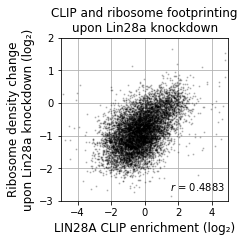

In [30]:
fig4, axd = plt.subplots(nrows=1, ncols=1, figsize=(3,3))

axd.scatter(x=dfLfc['clip-enrich'], y=dfLfc['rib-density-change'], s=1, alpha=0.2, color='black', zorder=10)
axd.set_xlim(-5, 5)
axd.set_ylim(-3, 2)

axd.grid(axis='both', zorder=1)

axd.set_title('CLIP and ribosome footprinting\nupon Lin28a knockdown', fontsize=12)
axd.set_xlabel('LIN28A CLIP enrichment (log\u2082)', fontsize=12)
axd.set_ylabel('Ribosome density change\nupon Lin28a knockdown (log\u2082)', fontsize=12)

fCorr = round(stats.pearsonr(dfLfc['clip-enrich'], dfLfc['rib-density-change'])[0], 4)
axd.text(1.5, -2.7, r'$r$' + f' = {fCorr}')

# 5. GO terms

## 5.1. Import Mouse Uniprot GO

In [47]:
dfMouseGoCc = pd.read_table('../reference-data/go/uniprot/uniprot-organism__Mus+musculus_.tab')
dfMouseGoCc = dfMouseGoCc[dfMouseGoCc['Organism'] == 'Mus musculus (Mouse)']
dfMouseGoCc.dropna(inplace=True)
dfMouseGoCc.reset_index(drop=True, inplace=True)
dfMouseGoCc

,Entry,Organism,Ensembl transcript,Gene ontology (cellular component)
0,Q99J83,Mus musculus (Mouse),ENSMUST00000039286;,Atg12-Atg5-Atg16 complex [GO:0034274]; autopha...
1,P10417,Mus musculus (Mouse),ENSMUST00000112751 [P10417-1];ENSMUST000001899...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...
2,O88597,Mus musculus (Mouse),ENSMUST00000130916;,autophagosome [GO:0005776]; cytoplasm [GO:0005...
3,Q3TTA7,Mus musculus (Mouse),ENSMUST00000226593 [Q3TTA7-1];ENSMUST000002277...,cytosol [GO:0005829]; membrane raft [GO:004512...
4,Q8K337,Mus musculus (Mouse),ENSMUST00000094782 [Q8K337-1];ENSMUST000001844...,cytosol [GO:0005829]; early endosome membrane ...
...,...,...,...,...
33871,S4R1D4,Mus musculus (Mouse),ENSMUST00000182958;,axon [GO:0030424]; cytosol [GO:0005829]; dendr...
33872,D3Z7A6,Mus musculus (Mouse),ENSMUST00000118860;,anchored component of membrane [GO:0031225]; p...
33873,G3X9I7,Mus musculus (Mouse),ENSMUST00000082183;,cytoplasmic ribonucleoprotein granule [GO:0036...
33874,F6WAU7,Mus musculus (Mouse),ENSMUST00000088696;,nucleus [GO:0005634]


In [48]:
dfMouseGoCc['txId'] = dfMouseGoCc['Ensembl transcript'].apply(lambda x: x.split(';')[0].split(' [')[0])
dfMouseGoCc

,Entry,Organism,Ensembl transcript,Gene ontology (cellular component),txId
0,Q99J83,Mus musculus (Mouse),ENSMUST00000039286;,Atg12-Atg5-Atg16 complex [GO:0034274]; autopha...,ENSMUST00000039286
1,P10417,Mus musculus (Mouse),ENSMUST00000112751 [P10417-1];ENSMUST000001899...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,ENSMUST00000112751
2,O88597,Mus musculus (Mouse),ENSMUST00000130916;,autophagosome [GO:0005776]; cytoplasm [GO:0005...,ENSMUST00000130916
3,Q3TTA7,Mus musculus (Mouse),ENSMUST00000226593 [Q3TTA7-1];ENSMUST000002277...,cytosol [GO:0005829]; membrane raft [GO:004512...,ENSMUST00000226593
4,Q8K337,Mus musculus (Mouse),ENSMUST00000094782 [Q8K337-1];ENSMUST000001844...,cytosol [GO:0005829]; early endosome membrane ...,ENSMUST00000094782
...,...,...,...,...,...
33871,S4R1D4,Mus musculus (Mouse),ENSMUST00000182958;,axon [GO:0030424]; cytosol [GO:0005829]; dendr...,ENSMUST00000182958
33872,D3Z7A6,Mus musculus (Mouse),ENSMUST00000118860;,anchored component of membrane [GO:0031225]; p...,ENSMUST00000118860
33873,G3X9I7,Mus musculus (Mouse),ENSMUST00000082183;,cytoplasmic ribonucleoprotein granule [GO:0036...,ENSMUST00000082183
33874,F6WAU7,Mus musculus (Mouse),ENSMUST00000088696;,nucleus [GO:0005634],ENSMUST00000088696


## 5.2. Match GO terms with GeneID

In [52]:
dfGencode = pd.read_table('../reference-data/genome/mouse/mm39/gencode/mm39.wgEncodeGencodeAttrsVM28.txt')[
    ['#geneId', 'geneName', 'transcriptId']
]
dfGencode['txId'] = dfGencode['transcriptId'].apply(lambda x: x.split('.')[0])
dfGencode

,#geneId,geneName,transcriptId,txId
0,ENSMUSG00000102693.2,4933401J01Rik,ENSMUST00000193812.2,ENSMUST00000193812
1,ENSMUSG00000064842.3,Gm26206,ENSMUST00000082908.3,ENSMUST00000082908
2,ENSMUSG00000051951.6,Xkr4,ENSMUST00000162897.2,ENSMUST00000162897
3,ENSMUSG00000051951.6,Xkr4,ENSMUST00000159265.2,ENSMUST00000159265
4,ENSMUSG00000051951.6,Xkr4,ENSMUST00000070533.5,ENSMUST00000070533
...,...,...,...,...
142430,ENSMUSG00000096768.9,Gm47283,ENSMUST00000238238.2,ENSMUST00000238238
142431,ENSMUSG00000096768.9,Gm47283,ENSMUST00000238471.2,ENSMUST00000238471
142432,ENSMUSG00000099871.2,Gm21742,ENSMUST00000189352.2,ENSMUST00000189352
142433,ENSMUSG00000096850.2,Gm21748,ENSMUST00000179623.2,ENSMUST00000179623


In [55]:
dfGeneIdGo = pd.merge(left=dfGencode, right=dfMouseGoCc, on='txId', how='inner')
dfGeneIdGo

,#geneId,geneName,transcriptId,txId,Entry,Organism,Ensembl transcript,Gene ontology (cellular component)
0,ENSMUSG00000051951.6,Xkr4,ENSMUST00000070533.5,ENSMUST00000070533,Q5GH67,Mus musculus (Mouse),ENSMUST00000070533;,integral component of membrane [GO:0016021]; m...
1,ENSMUSG00000025900.14,Rp1,ENSMUST00000027032.6,ENSMUST00000027032,P56716,Mus musculus (Mouse),ENSMUST00000027032;,axoneme [GO:0005930]; ciliary tip [GO:0097542]...
2,ENSMUSG00000025902.14,Sox17,ENSMUST00000027035.10,ENSMUST00000027035,Q61473,Mus musculus (Mouse),ENSMUST00000027035 [Q61473-1];ENSMUST000001166...,nucleus [GO:0005634]; transcription regulator ...
3,ENSMUSG00000025902.14,Sox17,ENSMUST00000192650.6,ENSMUST00000192650,A0A0A6YXS3,Mus musculus (Mouse),ENSMUST00000192650;,nucleus [GO:0005634]
4,ENSMUSG00000025902.14,Sox17,ENSMUST00000191647.2,ENSMUST00000191647,A0A0A6YXZ2,Mus musculus (Mouse),ENSMUST00000191647;,nucleus [GO:0005634]
...,...,...,...,...,...,...,...,...
33866,ENSMUSG00000095650.3,Gm20854,ENSMUST00000178889.2,ENSMUST00000178889,Q62461,Mus musculus (Mouse),ENSMUST00000178889;ENSMUST00000181549;,cytosol [GO:0005829]; nucleoplasm [GO:0005654]
33867,ENSMUSG00000100240.2,Gm20820,ENSMUST00000188754.2,ENSMUST00000188754,A0A087WPP3,Mus musculus (Mouse),ENSMUST00000188754;,synaptonemal complex [GO:0000795]
33868,ENSMUSG00000101915.2,Gm28102,ENSMUST00000187146.2,ENSMUST00000187146,A0A087WQL3,Mus musculus (Mouse),ENSMUST00000187146;,synaptonemal complex [GO:0000795]
33869,ENSMUSG00000102045.2,Gm21294,ENSMUST00000186443.2,ENSMUST00000186443,A0A087WS79,Mus musculus (Mouse),ENSMUST00000186443;,synaptonemal complex [GO:0000795]


## 5.3. Define categories

In [58]:
NUCLEUS                = 'GO:0005634'
INTEGRAL_MEMBRANE      = 'GO:0016021'
CYTOPLASM              = 'GO:0005737'
ER_ASSOCIATED          = {'GO:0016021', 'GO:0005576', 'GO:0009986', 'GO:0005794', 'GO:0005783'}
MITOCHONDRIAL_MEMBRANE = 'GO:0031966'

In [85]:
stNucleus = set(dfGeneIdGo[dfGeneIdGo['Gene ontology (cellular component)'].apply(
    lambda x: (NUCLEUS in x) and (MITOCHONDRIAL_MEMBRANE not in x)
)]['#geneId'].to_list())

In [86]:
stIntegralMembrane = set(dfGeneIdGo[dfGeneIdGo['Gene ontology (cellular component)'].apply(
    lambda x: (INTEGRAL_MEMBRANE in x) and (MITOCHONDRIAL_MEMBRANE not in x)
)]['#geneId'].to_list())

In [87]:
stCytoplasm = set(dfGeneIdGo[dfGeneIdGo['Gene ontology (cellular component)'].apply(
    lambda x: (CYTOPLASM in x) and (MITOCHONDRIAL_MEMBRANE not in x)
)]['#geneId'].to_list())

In [70]:
stRedundant = (stNucleus & stIntegralMembrane) | (stNucleus & stCytoplasm) | (stCytoplasm & stIntegralMembrane)

In [72]:
len(stRedundant)

2860

# 6. Figure 5B (Figure S6A)

+ Nucleus : Blud
+ Integral membrane : Red
+ Cytoplasm : Green
+ Proteins included in more than one group : Not plotted

Text(0, 0.5, 'Ribosome density change\nupon Lin28a knockdown (log₂)')

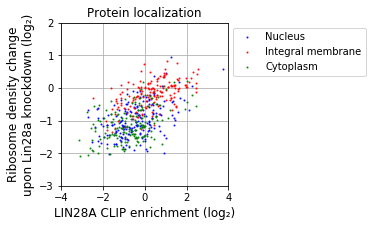

In [105]:
fig5, axb = plt.subplots(nrows=1, ncols=1, figsize=(3,3))

for local, colour, name in zip([stNucleus, stIntegralMembrane , stCytoplasm], 
                               ['blue', 'red', 'green'], 
                               ['Nucleus', 'Integral membrane', 'Cytoplasm']):
    axb.scatter(
        # index == GeneName|GeneID == i.e. Rpl7|ENSMUSG00000043716.14
        x=dfLfc[dfLfc['index'].apply(lambda x: x.split('|')[1] in (local - stRedundant))]['clip-enrich'].to_list()[::7], 
        y=dfLfc[dfLfc['index'].apply(lambda x: x.split('|')[1] in (local - stRedundant))]['rib-density-change'].to_list()[::7], 
        s=1.2, alpha=0.8, color=colour, label=name, zorder=10
    )
axb.legend(loc='upper left', bbox_to_anchor=(1, 1))
axb.set_xlim(-4, 4)
axb.set_ylim(-3, 2)

axb.grid(axis='both', zorder=1)

axb.set_title('Protein localization', fontsize=12)
axb.set_xlabel('LIN28A CLIP enrichment (log\u2082)', fontsize=12)
axb.set_ylabel('Ribosome density change\nupon Lin28a knockdown (log\u2082)', fontsize=12)